In [1]:
import numpy as np
import matplotlib.pyplot as plt

from typing import List

In [2]:
from modules_importer import get_reloader
from modules import models
from modules import experiment as exp
from modules import plots, fitting, evaluation, utils
reloader = get_reloader(models, exp, plots, fitting, evaluation, utils)

In [3]:
reloader()

In [4]:
fitted_models: List[models.BasicHadronicModelSED] = []
objects = [o.with_normal_errors() for o in exp.all_objects]
# objects = exp.all_objects

for obj in objects:
    print('=' * 15)
    print(obj.name)
    print('=' * 15)

    model = models.BasicHadronicModelSED.at_z(obj.z)
    # not varying experimental energy scale
    exp_E_varying_config = fitting.ExpSedEnergyVaryingConfig.for_object(obj, False)

    shifted_objs = []

    model_params, E_factors = fitting.fit_model_to_object(obj, model, exp_E_varying=exp_E_varying_config)
    print(f'model params: {", ".join(str(p) for p in model_params)}')
    model.set_parameters(*model_params)

    fitted_models.append(model)


1ES1218+304 (normal errors)
optimizing model...
optimization result: Optimization terminated successfully.
model params: 0.9111859321594236
1ES1101-232 (normal errors)
optimizing model...
optimization result: Optimization terminated successfully.
model params: 0.15341300964355395
1ES0347-121 (normal errors)
optimizing model...
optimization result: Optimization terminated successfully.
model params: 0.13246402740478436
1ES0229+200 (normal errors)
optimizing model...
optimization result: Optimization terminated successfully.
model params: 1.5754796981811539
1ES0414+009 (normal errors)
optimizing model...
optimization result: Optimization terminated successfully.
model params: 0.9790171623229978


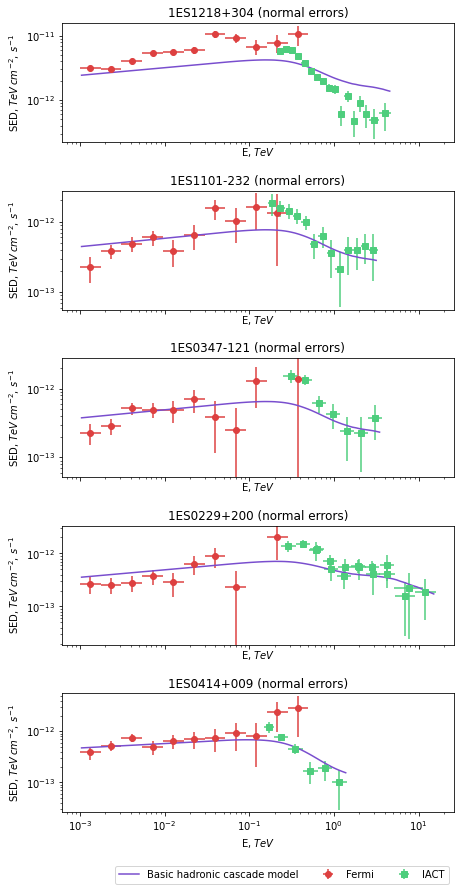

In [5]:
n_plots = len(objects)

fig, axes = plt.subplots(
    nrows=n_plots + 1, ncols=1, sharex=True, figsize=(6.5, n_plots*2.5),
    gridspec_kw={'height_ratios': [1] * n_plots + [0.2]},
)
axes: List[plt.Axes]

for ax, obj, model in zip(axes, objects, fitted_models):
    obj.plot(ax, adjust_ylim_with_pad=0.05)
    model.plot(ax, *utils.enlarge_log_interval(obj.E_min, obj.E_max, pad=0))
    ax.set_title(obj.name)

ax.tick_params(axis='x', labelbottom=True)

legend_ax = axes[-1]
handles, labels = ax.get_legend_handles_labels()
legend_ax.legend(handles, labels, ncol=3)
legend_ax.set_axis_off()

plt.tight_layout()

# fig.savefig('../pics/objectwise-basic-analysis-okerrors.png', bbox_inches='tight', pad_inches=0)
plt.show()

# $\sigma$-values estimation

In [6]:
from scipy import stats
import math

def print_sigma_from_chi2_value(chi2_val, k, m):
    """k is a number of data points, m is a number of varied parameters"""
    chi2_r = stats.chi2(df=k - m - 1)
    p_value = 1 - chi2_r.cdf(chi2_val)
    z = stats.norm.interval(alpha=1 - p_value)[1]
    MAX_CALCULATABLE_Z = 8.125890664701908
    z_str = f"{z:.2f}" if z != math.inf else f"> {MAX_CALCULATABLE_Z:.2f}"
    print(f'significance of rejecting the hypothesis: {z_str} sigma ({p_value = :.2e})')

In [9]:
chi_sq_n_pts_by_object_name = dict()

for obj, model in zip(objects, fitted_models):
    ll = obj.get_joint_loglike(model)(model.get_parameters(), exp_E_varying_config.E_factors_from_varying_E_factors([]))
    chi_sq = 2 * np.abs(ll)
    chi_sq_n_pts_by_object_name[obj.name] = (chi_sq, obj.n_points)
    print('\n' + '=' * 10 + obj.name + '=' * 10)
    print(f'{obj.n_points = }, {chi_sq = }')
    print_sigma_from_chi2_value(chi_sq, k=obj.n_points, m=1)


==========1ES1218+304 (normal errors)==========
obj.n_points = 28, chi_sq = 405.5034846998526
significance of rejecting the hypothesis: > 8.13 sigma (p_value = 0.00e+00)

==========1ES1101-232 (normal errors)==========
obj.n_points = 23, chi_sq = 34.44149507727511
significance of rejecting the hypothesis: 2.14 sigma (p_value = 3.25e-02)

==========1ES0347-121 (normal errors)==========
obj.n_points = 17, chi_sq = 35.06147677828005
significance of rejecting the hypothesis: 3.03 sigma (p_value = 2.41e-03)

==========1ES0229+200 (normal errors)==========
obj.n_points = 26, chi_sq = 46.08336924371049
significance of rejecting the hypothesis: 2.85 sigma (p_value = 4.33e-03)

==========1ES0414+009 (normal errors)==========
obj.n_points = 17, chi_sq = 18.769416025561007
significance of rejecting the hypothesis: 1.21 sigma (p_value = 2.24e-01)


## Galkin's results:

```
source         p-value       Cher.shift, %    chi2   ndf    Z-value
1ES1218+304      1.58E-59         +30          358.1   27     >5.850
1ES1101-232      0.152            -19           28.7   22      1.028
1ES0347-121      0.147            -24           21.9   16      1.049
1ES0229+200      0.182            -19           31.2   25      0.908
1ES0414+009      0.00015          +11           44.8   16      3.615
```

Comparison:

```
source         Z-value-Galkin  Z-value-Vaiman
1ES1218+304    >5.850          >8.13
1ES1101-232    1.028           2.14
1ES0347-121    1.049           3.03
1ES0229+200    0.908           2.85
1ES0414+009    3.615           1.21
```

## Combined significance

In [14]:
def combined_sigma_for_objects(objs: List[exp.Object], list_name: str) -> float:
    total_chi_sq = 0
    total_n_pts = 0
    total_tuned_params = len(objs)
    for o in objs:
        chi_sq, n_pts = chi_sq_n_pts_by_object_name[o.name]
        total_chi_sq += chi_sq
        total_n_pts += n_pts
    
    print(f"Combined for {list_name}\n" + ", ".join([o.name for o in objs]))
    print_sigma_from_chi2_value(total_chi_sq, k=total_n_pts, m=total_tuned_params)


In [15]:
combined_sigma_for_objects(objects, "all objects")
combined_sigma_for_objects(objects[1:], "all objects except the first")

Combined for all objects
1ES1218+304 (normal errors), 1ES1101-232 (normal errors), 1ES0347-121 (normal errors), 1ES0229+200 (normal errors), 1ES0414+009 (normal errors)
significance of rejecting the hypothesis: > 8.13 sigma (p_value = 0.00e+00)
Combined for all objects except the first
1ES1101-232 (normal errors), 1ES0347-121 (normal errors), 1ES0229+200 (normal errors), 1ES0414+009 (normal errors)
significance of rejecting the hypothesis: 3.95 sigma (p_value = 7.70e-05)
